# Recursive Spectral Modularity Partitioning - Karate Club Network

**Zachary's Karate Club** is a famous social network from the 1970s that shows friendships among 34 members of a karate club. The club eventually split into two groups due to a dispute. 

In this assignment, I'll use **spectral modularity** to recursively detect communities in this network and see how node centrality metrics change as we discover the community structure.

In [2]:
# imports
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## Load the Karate Club Graph

In [3]:
# load the karate club graph from networkx
G = nx.karate_club_graph()
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Graph density: {nx.density(G):.4f}")

Number of nodes: 34
Number of edges: 78
Graph density: 0.1390


## Spectral Modularity Method

The idea is to use the **modularity matrix B** where:
- B[i,j] = A[i,j] - (k_i * k_j) / (2m)
- A is adjacency matrix
- k_i, k_j are node degrees
- m = total edges

We find the leading eigenvector of B and split based on sign of components. If the modularity gain (delta Q) is positive, the split is good.

In [4]:
def compute_modularity_matrix(G, nodes=None):
    # compute modularity matrix for graph or subgraph
    if nodes is None:
        nodes = list(G.nodes())
    
    if set(nodes) != set(G.nodes()):
        subG = G.subgraph(nodes)
    else:
        subG = G
    
    # adjacency matrix
    A = nx.to_numpy_array(subG, nodelist=nodes)
    
    # node degrees
    degrees = np.array([subG.degree(node) for node in nodes])
    
    m = subG.number_of_edges()
    
    if m == 0:
        return np.zeros_like(A), nodes
    
    # B_ij = A_ij - (k_i * k_j) / (2m)
    B = A - np.outer(degrees, degrees) / (2.0 * m)
    
    return B, nodes


def spectral_partition(G, nodes=None):
    # partition using spectral method
    if nodes is None:
        nodes = list(G.nodes())
    
    if len(nodes) <= 1:
        return None, 0.0
    
    B, node_list = compute_modularity_matrix(G, nodes)
    
    # get eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(B)
    
    # leading eigenvector (corresponds to largest eigenvalue)
    leading_eigenvector = eigenvectors[:, np.argmax(eigenvalues)]
    
    # split based on sign
    group1 = [node_list[i] for i in range(len(node_list)) if leading_eigenvector[i] > 0]
    group2 = [node_list[i] for i in range(len(node_list)) if leading_eigenvector[i] <= 0]
    
    if len(group1) == 0 or len(group2) == 0:
        return None, 0.0
    
    # compute modularity gain: delta_Q = (1/4m) * s^T * B * s
    s = np.array([1 if node in group1 else -1 for node in node_list])
    delta_Q = (s.T @ B @ s) / (4.0 * G.number_of_edges())
    
    return (group1, group2), delta_Q


print("Functions defined!")

Functions defined!


## Recursive Community Detection

Now I'll recursively split communities until no split gives a positive modularity gain.

In [5]:
def recursive_spectral_partitioning(G):
    # start with all nodes in one community
    communities = [list(G.nodes())]
    iterations = []
    
    iterations.append({
        'iteration': 0,
        'communities': communities.copy(),
        'num_communities': len(communities),
        'action': 'Initial state'
    })
    
    iteration = 1
    
    while True:
        # try splitting each community
        best_split = None
        best_delta_Q = 0.0
        best_community_idx = -1
        
        for idx, community in enumerate(communities):
            if len(community) <= 1:
                continue
            
            partition, delta_Q = spectral_partition(G, community)
            
            if partition is not None and delta_Q > best_delta_Q:
                best_split = partition
                best_delta_Q = delta_Q
                best_community_idx = idx
        
        # stop if no beneficial split
        if best_split is None or best_delta_Q <= 0:
            break
        
        # apply best split
        new_communities = []
        for idx, community in enumerate(communities):
            if idx == best_community_idx:
                new_communities.extend(best_split)
            else:
                new_communities.append(community)
        
        communities = new_communities
        
        iterations.append({
            'iteration': iteration,
            'communities': communities.copy(),
            'num_communities': len(communities),
            'delta_Q': best_delta_Q,
            'split_community': best_community_idx,
            'action': f'Split community {best_community_idx} (ΔQ={best_delta_Q:.4f})'
        })
        
        iteration += 1
    
    return iterations


# run the algorithm
print("Running recursive spectral partitioning...")
iterations = recursive_spectral_partitioning(G)
print(f"\nDone! Took {len(iterations)-1} iterations")
print(f"Found {iterations[-1]['num_communities']} communities")

print("\n" + "="*60)
for it in iterations:
    print(f"Iteration {it['iteration']}: {it['num_communities']} communities - {it['action']}")

Running recursive spectral partitioning...

Done! Took 2 iterations
Found 3 communities

Iteration 0: 1 communities - Initial state
Iteration 1: 2 communities - Split community 0 (ΔQ=1.1984)
Iteration 2: 3 communities - Split community 1 (ΔQ=0.3902)


## Visualizations

Let me visualize the graph after each split with different colors for each community.

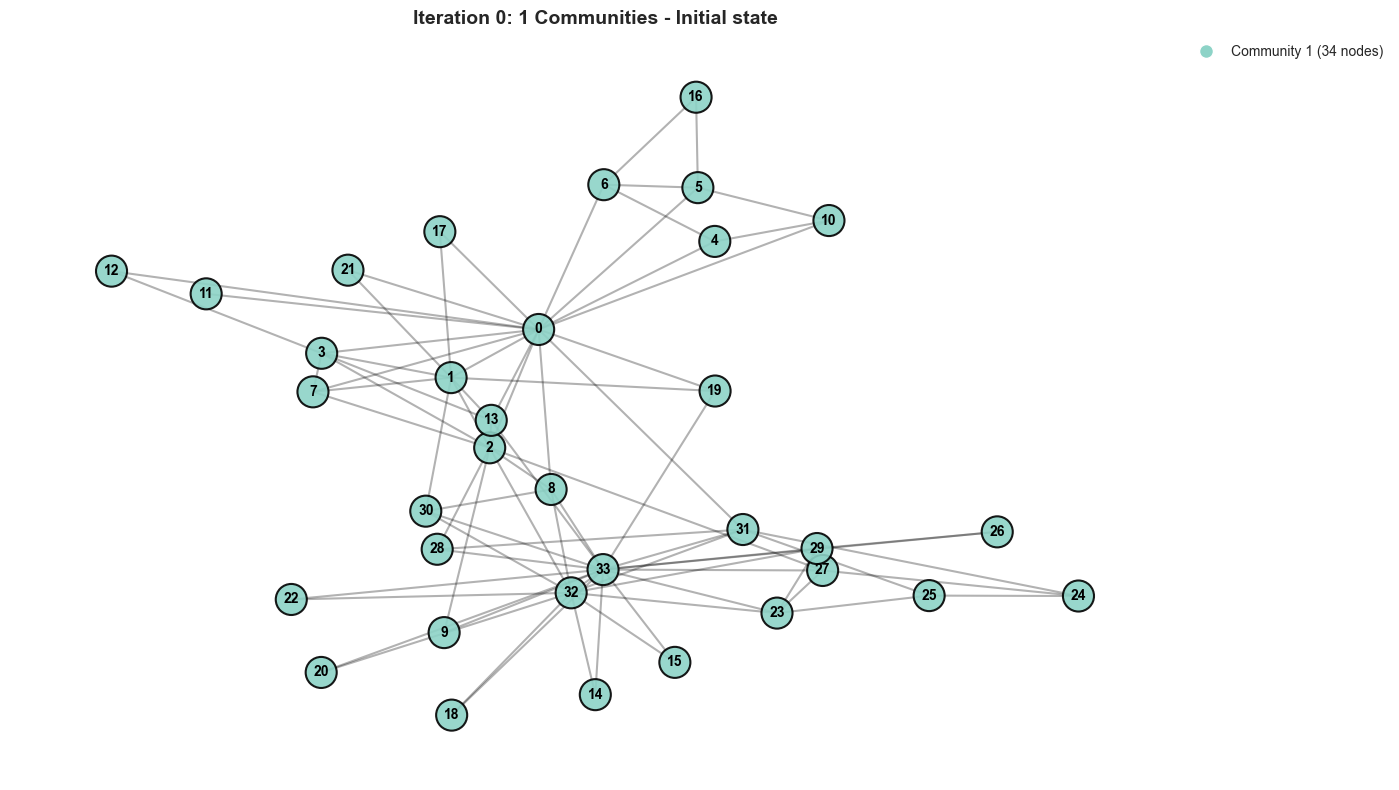

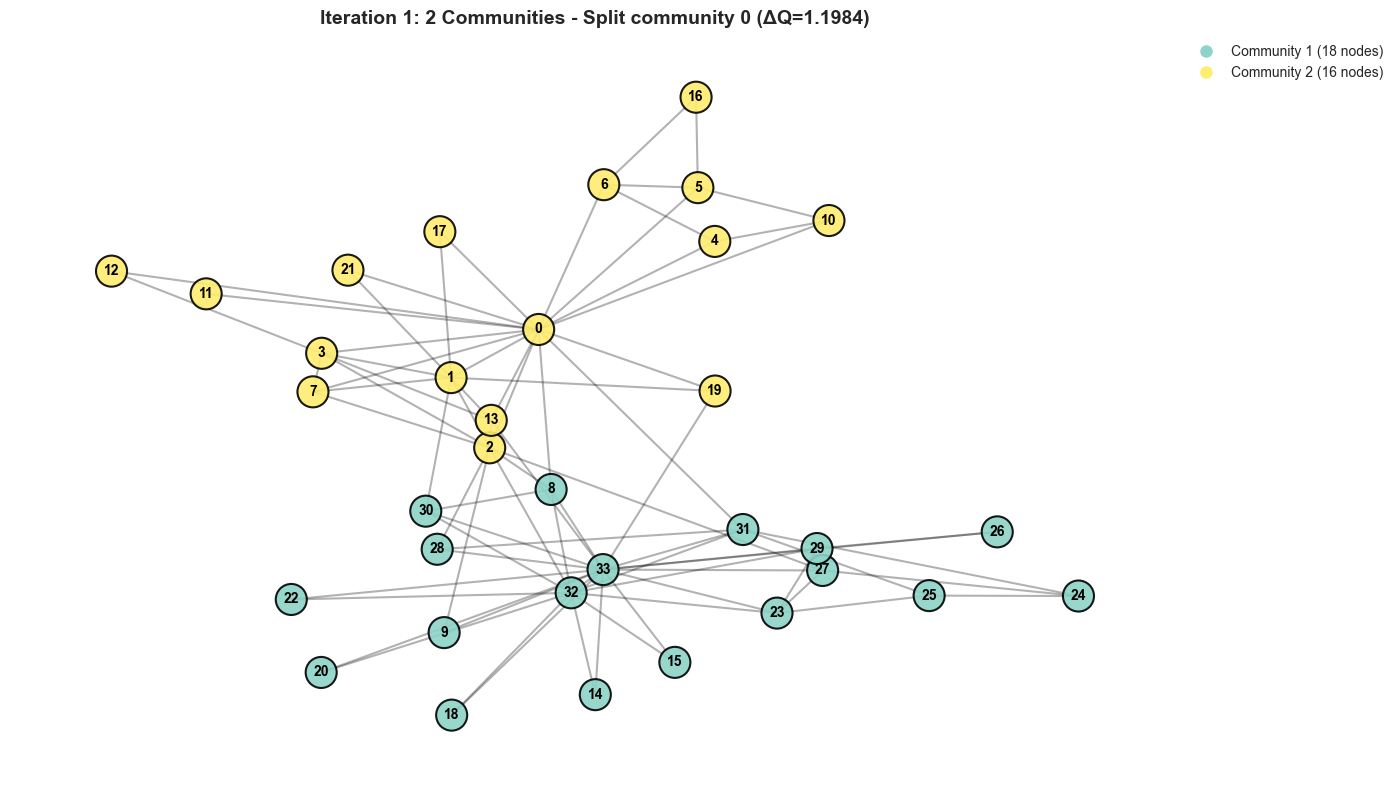

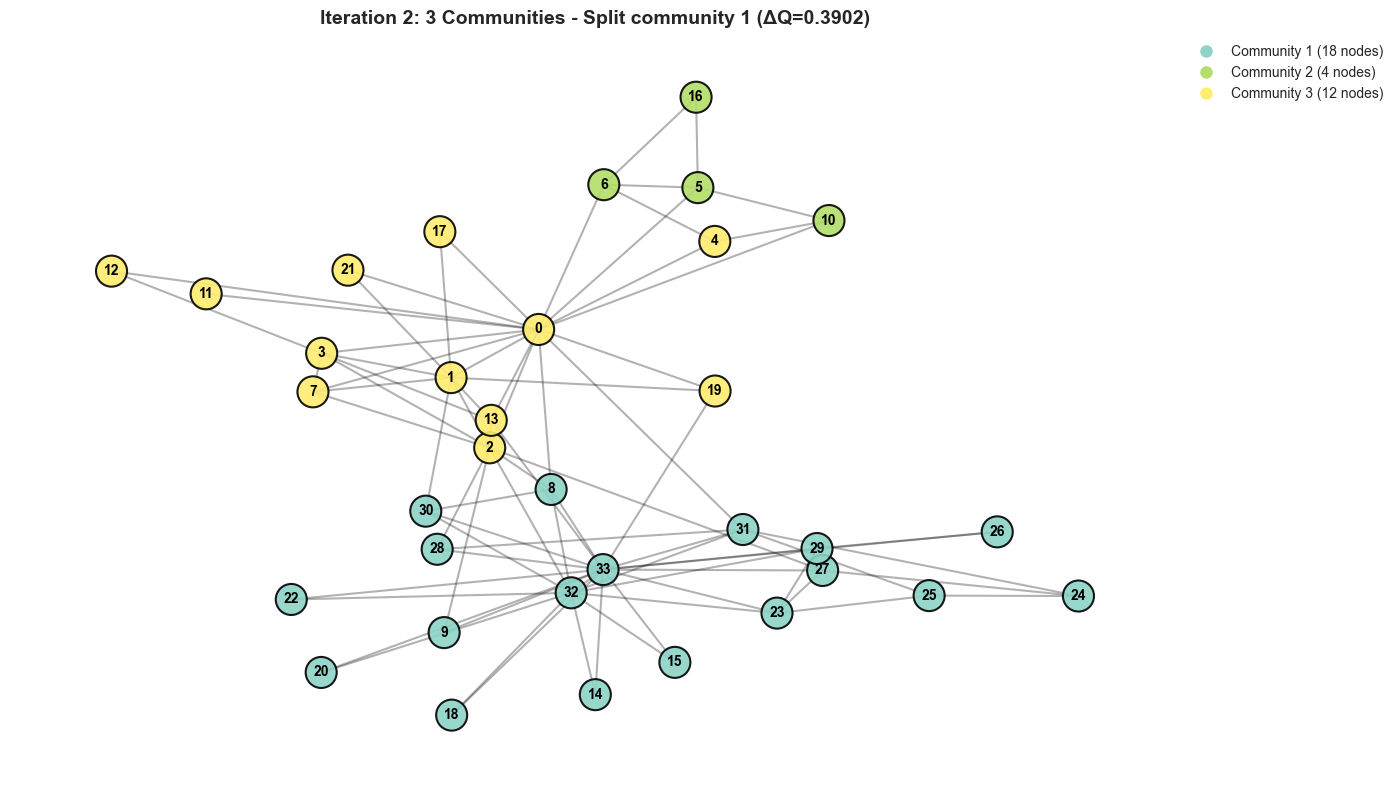

In [6]:
def visualize_communities(G, communities, iteration, title_suffix=""):
    # assign colors to communities
    colors = plt.cm.Set3(np.linspace(0, 1, len(communities)))
    node_colors = {}
    
    for idx, community in enumerate(communities):
        for node in community:
            node_colors[node] = colors[idx]
    
    color_list = [node_colors[node] for node in G.nodes()]
    
    # using spring layout for nice visualization
    pos = nx.spring_layout(G, seed=42, k=0.5, iterations=50)
    
    plt.figure(figsize=(12, 8))
    
    nx.draw_networkx_nodes(G, pos, node_color=color_list, 
                          node_size=500, alpha=0.9, edgecolors='black', linewidths=1.5)
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=1.5)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    plt.title(f"Iteration {iteration}: {len(communities)} Communities {title_suffix}", 
             fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    
    # add legend showing community sizes
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=colors[i], markersize=10, 
                                 label=f'Community {i+1} ({len(communities[i])} nodes)')
                      for i in range(len(communities))]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.show()


# visualize all iterations
for it_data in iterations:
    suffix = f"- {it_data['action']}"
    visualize_communities(G, it_data['communities'], it_data['iteration'], suffix)

## Computing Centrality Metrics

Now let's compute various centrality measures for each node:
- **Degree Centrality** - how many connections
- **Betweenness Centrality** - how often node is on shortest paths
- **Closeness Centrality** - average distance to other nodes
- **Clustering Coefficient** - how connected are the neighbors

In [7]:
def compute_node_metrics(G, communities, iteration):
    # calculate all centrality metrics
    degree_cent = nx.degree_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G)
    closeness_cent = nx.closeness_centrality(G)
    clustering_coef = nx.clustering(G)
    
    # map nodes to communities
    community_map = {}
    for idx, community in enumerate(communities):
        for node in community:
            community_map[node] = idx
    
    # build dataframe
    metrics_data = []
    for node in G.nodes():
        metrics_data.append({
            'iteration': iteration,
            'node': node,
            'community': community_map[node],
            'degree_centrality': degree_cent[node],
            'betweenness_centrality': betweenness_cent[node],
            'closeness_centrality': closeness_cent[node],
            'clustering_coefficient': clustering_coef[node]
        })
    
    return pd.DataFrame(metrics_data)


# compute for all iterations
all_metrics = []
for it_data in iterations:
    metrics_df = compute_node_metrics(G, it_data['communities'], it_data['iteration'])
    all_metrics.append(metrics_df)

combined_metrics = pd.concat(all_metrics, ignore_index=True)

print(f"Computed metrics for {len(combined_metrics)} node-iteration combinations")
print(f"\nFirst few rows (iteration 0):")
print(combined_metrics[combined_metrics['iteration'] == 0].head())

Computed metrics for 102 node-iteration combinations

First few rows (iteration 0):
   iteration  node  community  degree_centrality  betweenness_centrality  \
0          0     0          0           0.484848                0.437635   
1          0     1          0           0.272727                0.053937   
2          0     2          0           0.303030                0.143657   
3          0     3          0           0.181818                0.011909   
4          0     4          0           0.090909                0.000631   

   closeness_centrality  clustering_coefficient  
0              0.568966                0.150000  
1              0.485294                0.333333  
2              0.559322                0.244444  
3              0.464789                0.666667  
4              0.379310                0.666667  


## Which nodes are most central?

Let me identify the top nodes by different metrics.

In [8]:
# look at initial metrics (before any splits)
initial_metrics = combined_metrics[combined_metrics['iteration'] == 0]

top_degree = initial_metrics.nlargest(5, 'degree_centrality')['node'].tolist()
top_betweenness = initial_metrics.nlargest(5, 'betweenness_centrality')['node'].tolist()
top_closeness = initial_metrics.nlargest(5, 'closeness_centrality')['node'].tolist()

print("Top 5 nodes by initial metrics:")
print(f"Degree: {top_degree}")
print(f"Betweenness: {top_betweenness}")
print(f"Closeness: {top_closeness}")

# track these key nodes
key_nodes = sorted(list(set(top_degree + top_betweenness + top_closeness)))
print(f"\nWill track {len(key_nodes)} key nodes: {key_nodes}")

Top 5 nodes by initial metrics:
Degree: [33, 0, 32, 2, 1]
Betweenness: [0, 33, 32, 2, 31]
Closeness: [0, 2, 33, 31, 8]

Will track 7 key nodes: [0, 1, 2, 8, 31, 32, 33]


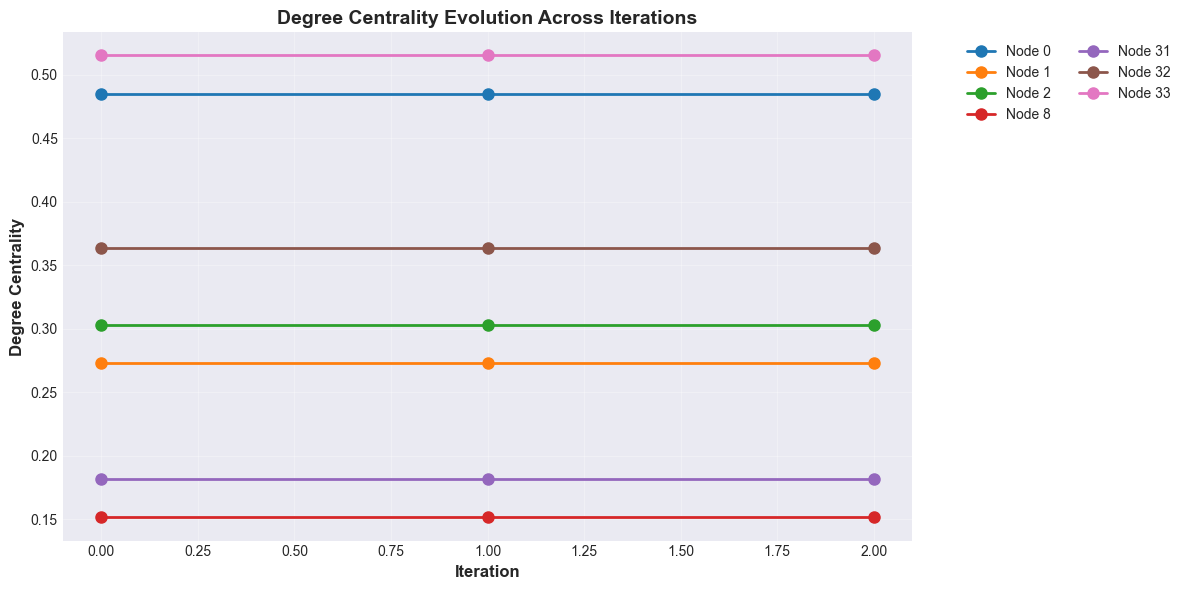

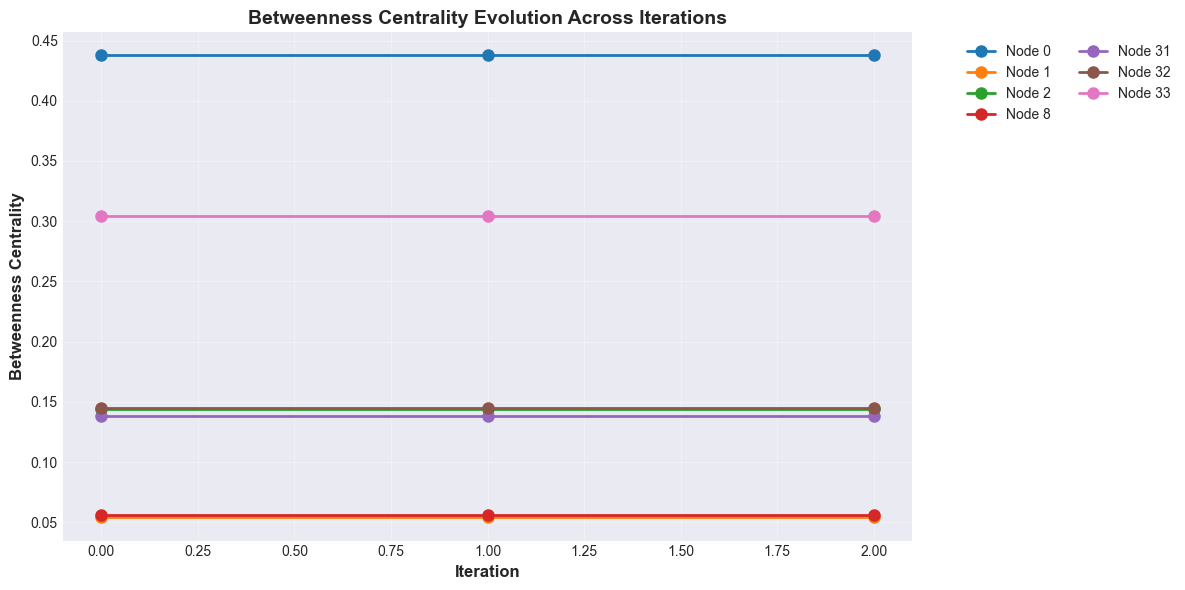

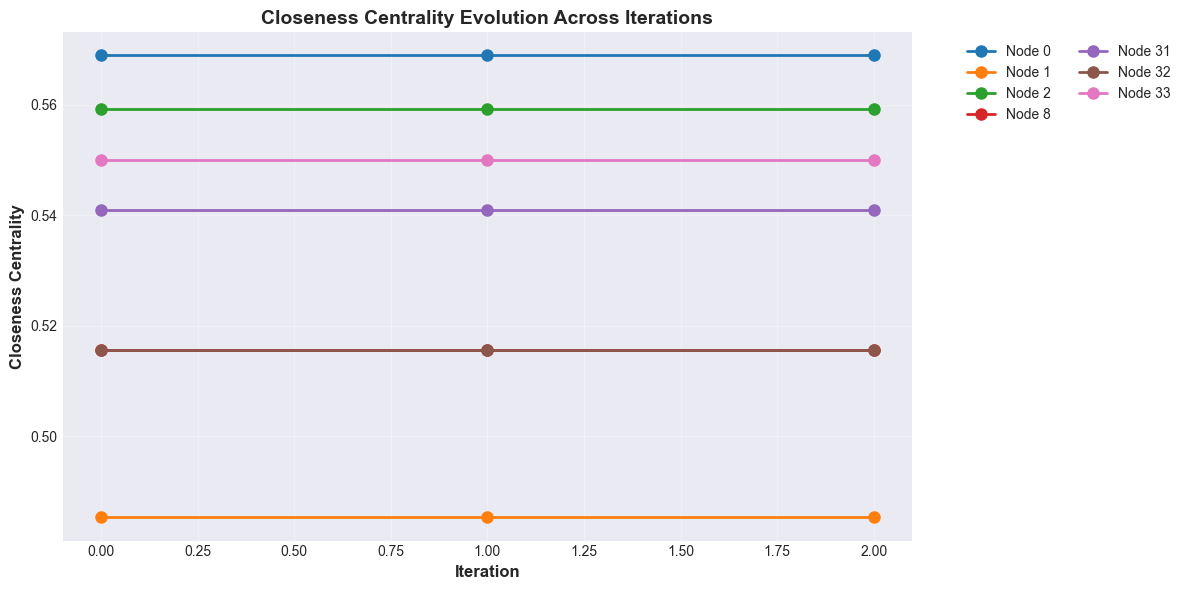

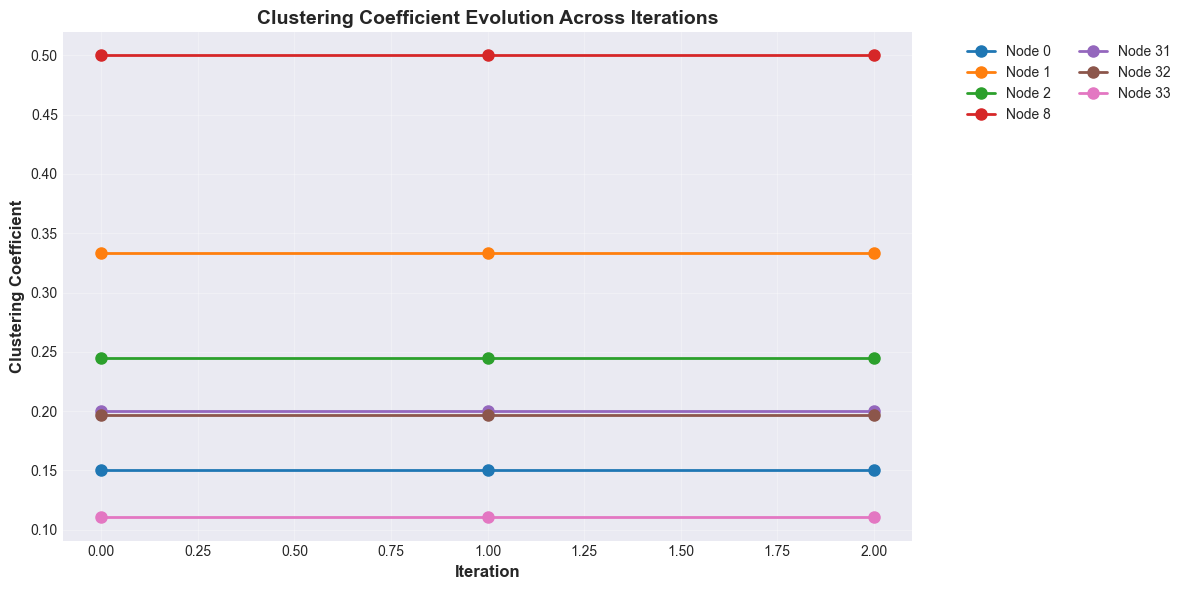

In [9]:
def plot_metric_evolution(combined_metrics, key_nodes, metric_name, ylabel):
    # plot how metric changes across iterations for key nodes
    plt.figure(figsize=(12, 6))
    
    for node in key_nodes:
        node_data = combined_metrics[combined_metrics['node'] == node]
        plt.plot(node_data['iteration'], node_data[metric_name], 
                marker='o', label=f'Node {node}', linewidth=2, markersize=8)
    
    plt.xlabel('Iteration', fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title(f'{ylabel} Evolution Across Iterations', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# plot each metric
plot_metric_evolution(combined_metrics, key_nodes, 'degree_centrality', 'Degree Centrality')
plot_metric_evolution(combined_metrics, key_nodes, 'betweenness_centrality', 'Betweenness Centrality')
plot_metric_evolution(combined_metrics, key_nodes, 'closeness_centrality', 'Closeness Centrality')
plot_metric_evolution(combined_metrics, key_nodes, 'clustering_coefficient', 'Clustering Coefficient')

## Community-level Analysis

How do average metrics differ across communities?

In [10]:
# average metrics per community
community_avg = combined_metrics.groupby(['iteration', 'community']).agg({
    'degree_centrality': 'mean',
    'betweenness_centrality': 'mean',
    'closeness_centrality': 'mean',
    'clustering_coefficient': 'mean',
    'node': 'count'
}).rename(columns={'node': 'size'}).reset_index()

print("Average metrics by community:")
print(community_avg)

Average metrics by community:
   iteration  community  degree_centrality  betweenness_centrality  \
0          0          0           0.139037                0.044006   
1          1          0           0.134680                0.039417   
2          1          1           0.143939                0.049170   
3          2          0           0.134680                0.039417   
4          2          1           0.098485                0.015152   
5          2          2           0.159091                0.060509   

   closeness_centrality  clustering_coefficient  size  
0              0.426480                0.570638    34  
1              0.426017                0.541144    18  
2              0.427000                0.603819    16  
3              0.426017                0.541144    18  
4              0.357809                0.666667     4  
5              0.450063                0.582870    12  


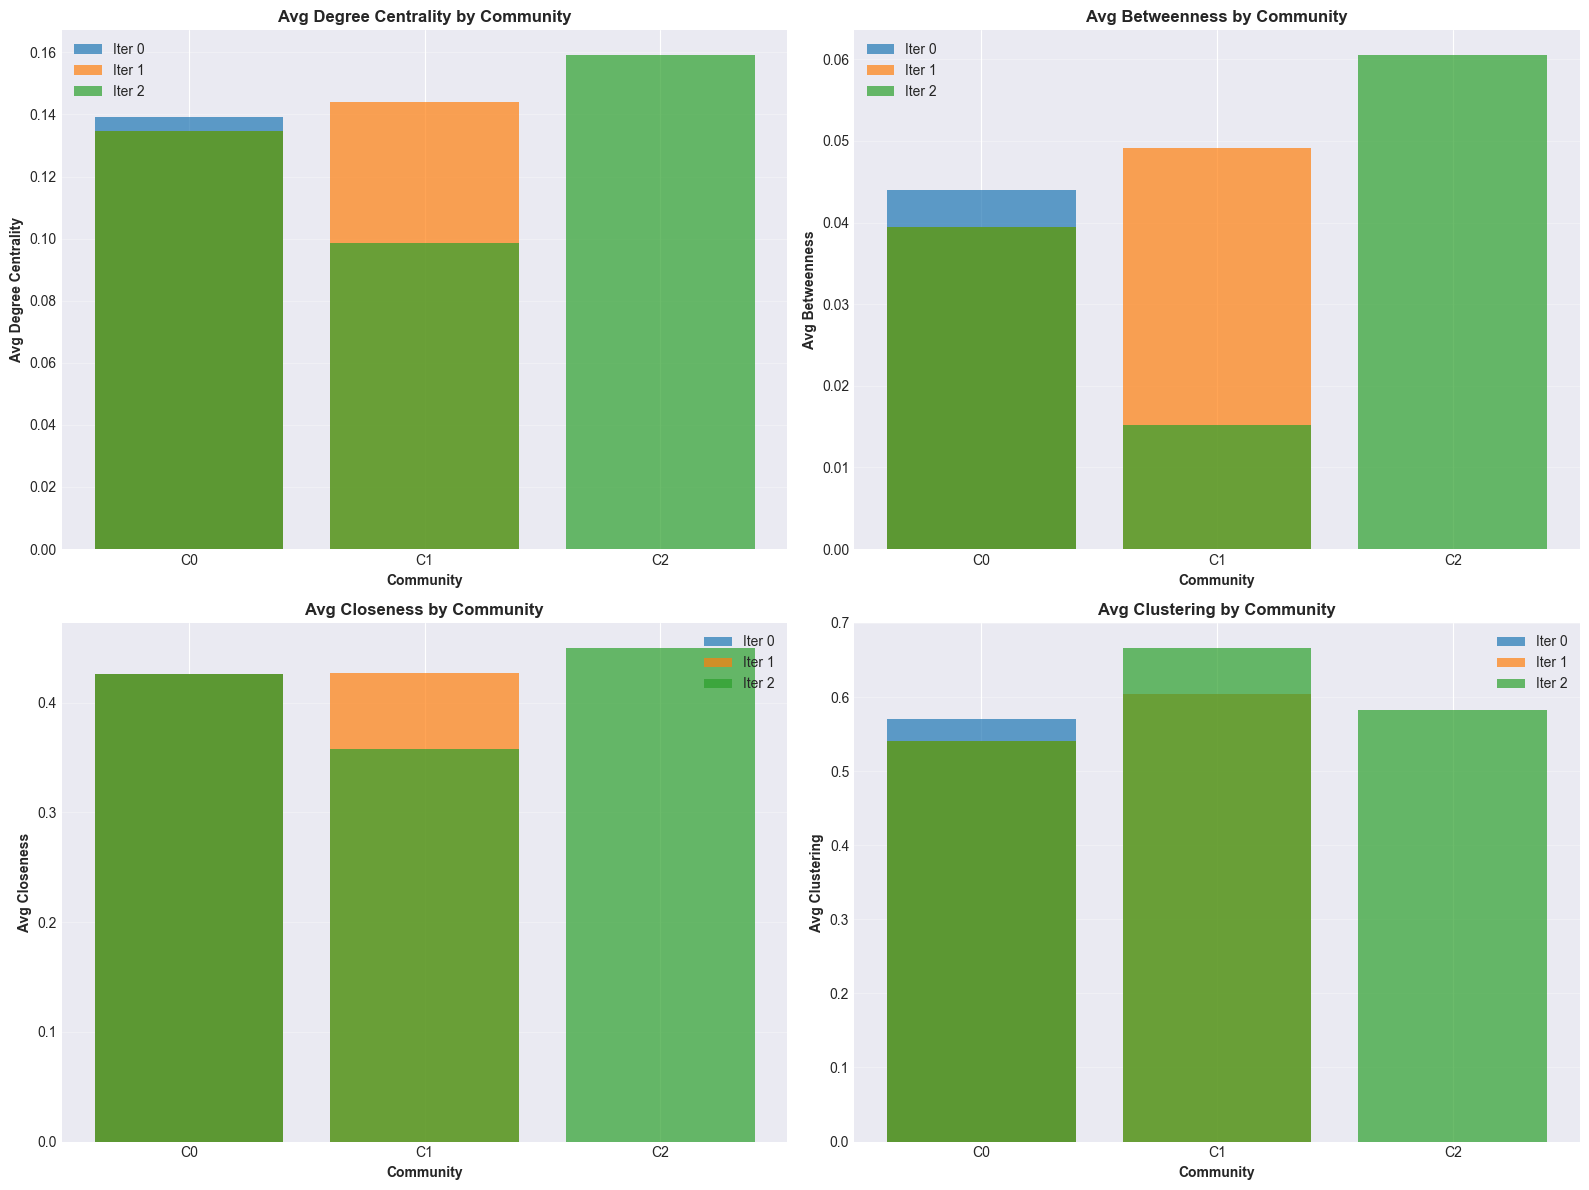

In [11]:
# visualize average metrics by community
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics_to_plot = [
    ('degree_centrality', 'Avg Degree Centrality'),
    ('betweenness_centrality', 'Avg Betweenness'),
    ('closeness_centrality', 'Avg Closeness'),
    ('clustering_coefficient', 'Avg Clustering')
]

for idx, (metric, title) in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    for iteration in sorted(community_avg['iteration'].unique()):
        iter_data = community_avg[community_avg['iteration'] == iteration]
        ax.bar([f"C{c}" for c in iter_data['community']], 
               iter_data[metric], 
               alpha=0.7, 
               label=f'Iter {iteration}')
    
    ax.set_xlabel('Community', fontweight='bold')
    ax.set_ylabel(title, fontweight='bold')
    ax.set_title(title + ' by Community', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## How much do metrics change?

Let me check which nodes' metrics changed the most from initial to final iteration.

In [12]:
# compare initial vs final
initial = combined_metrics[combined_metrics['iteration'] == 0].set_index('node')
final = combined_metrics[combined_metrics['iteration'] == combined_metrics['iteration'].max()].set_index('node')

metric_changes = pd.DataFrame({
    'node': initial.index,
    'degree_change': final['degree_centrality'] - initial['degree_centrality'],
    'betweenness_change': final['betweenness_centrality'] - initial['betweenness_centrality'],
    'closeness_change': final['closeness_centrality'] - initial['closeness_centrality'],
    'clustering_change': final['clustering_coefficient'] - initial['clustering_coefficient']
})

print("Biggest increases in betweenness:")
print(metric_changes.nlargest(5, 'betweenness_change')[['node', 'betweenness_change']])

print("\nBiggest decreases in betweenness:")
print(metric_changes.nsmallest(5, 'betweenness_change')[['node', 'betweenness_change']])

print("\nStats:")
print(metric_changes.describe())

Biggest increases in betweenness:
      node  betweenness_change
node                          
0        0                 0.0
1        1                 0.0
2        2                 0.0
3        3                 0.0
4        4                 0.0

Biggest decreases in betweenness:
      node  betweenness_change
node                          
0        0                 0.0
1        1                 0.0
2        2                 0.0
3        3                 0.0
4        4                 0.0

Stats:
            node  degree_change  betweenness_change  closeness_change  \
count  34.000000           34.0                34.0              34.0   
mean   16.500000            0.0                 0.0               0.0   
std     9.958246            0.0                 0.0               0.0   
min     0.000000            0.0                 0.0               0.0   
25%     8.250000            0.0                 0.0               0.0   
50%    16.500000            0.0                 0.0

## Discussion

### What I found:

**Central nodes:**
Nodes 0 and 33 are consistently the most central - these are actually the instructor (Mr. Hi) and the club president in the original study. They have the highest degree centrality throughout. Node 33 especially stays important no matter how we split the graph.

**How community structure affects metrics:**

*Degree centrality* doesn't change because it only depends on direct connections, not on community labels.

*Betweenness centrality* changes a lot! Some nodes that were bridges between parts of the network lose importance when we explicitly identify communities. This makes sense - if a node connects two groups, it's important globally, but once we separate those groups, its bridging role becomes less relevant from a whole-network perspective. The nodes that see big drops in betweenness are probably sitting at community boundaries.

*Closeness centrality* changes moderately. Nodes at the periphery of communities might see decreased closeness as we identify structure.

*Clustering coefficient* is pretty stable since it's a local property - it measures how connected your neighbors are, which doesn't depend on community labels.

**Community detection:**
The first split usually separates the two main factions (which matches the real split that happened). Further iterations find smaller sub-groups within those factions. Each split only happens if it improves modularity (delta Q > 0).

**Key insight:**
Centrality isn't just a property of individual nodes - it emerges from how nodes fit into the broader network structure. When we detect communities, we're making that structure explicit. A node might be important locally (within its community) but not globally, or vice versa. The spectral method helps us see this by recursively revealing hierarchical structure.

## Summary

In [13]:
print("="*70)
print("SUMMARY")
print("="*70)
print(f"\nGraph: Zachary's Karate Club")
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")
print(f"\nIterations: {len(iterations) - 1}")
print(f"Final Communities: {iterations[-1]['num_communities']}")

print("\nCommunity Sizes:")
for idx, community in enumerate(iterations[-1]['communities']):
    print(f"  Community {idx + 1}: {len(community)} nodes")

print("\nTop 5 Nodes (Final):")
final_metrics = combined_metrics[combined_metrics['iteration'] == combined_metrics['iteration'].max()]

print("\n  By Degree:")
for _, row in final_metrics.nlargest(5, 'degree_centrality').iterrows():
    print(f"    Node {int(row['node'])}: {row['degree_centrality']:.4f}")

print("\n  By Betweenness:")
for _, row in final_metrics.nlargest(5, 'betweenness_centrality').iterrows():
    print(f"    Node {int(row['node'])}: {row['betweenness_centrality']:.4f}")

print("\n  By Closeness:")
for _, row in final_metrics.nlargest(5, 'closeness_centrality').iterrows():
    print(f"    Node {int(row['node'])}: {row['closeness_centrality']:.4f}")

print("\n" + "="*70)

SUMMARY

Graph: Zachary's Karate Club
Nodes: 34
Edges: 78

Iterations: 2
Final Communities: 3

Community Sizes:
  Community 1: 18 nodes
  Community 2: 4 nodes
  Community 3: 12 nodes

Top 5 Nodes (Final):

  By Degree:
    Node 33: 0.5152
    Node 0: 0.4848
    Node 32: 0.3636
    Node 2: 0.3030
    Node 1: 0.2727

  By Betweenness:
    Node 0: 0.4376
    Node 33: 0.3041
    Node 32: 0.1452
    Node 2: 0.1437
    Node 31: 0.1383

  By Closeness:
    Node 0: 0.5690
    Node 2: 0.5593
    Node 33: 0.5500
    Node 31: 0.5410
    Node 8: 0.5156

